# This notebook talke the raw output from Hamiltonian Replica Exchange, extract the dihedral angle from xtc file using MdTraj, and ananlyze the autocoorelation curve

In [1]:
import os, sys, glob, shutil, re
import subprocess

import mdtraj as md
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import math
from IPython.display import Image, display
%matplotlib inline
nmer = 5
mpl.rcParams.update({'font.size': 16})

In [2]:
%pwd

'/Users/starwingchen/Voelz_Lab/git/peptoid_24summer/peptoid/17AB2-8-A/GAFF/neutral/HREX_300ns'

In [4]:
import os
import subprocess

# Loop through each directory in the current working directory
for state_dir in os.listdir('.'):
    if os.path.isdir(state_dir) and state_dir.startswith('state_'):

        input_gro = os.path.join(state_dir, 'HREMD.part0001.gro')
        output_gro = os.path.join(state_dir, 'HREMD_withoutsolvent.part0001.gro')
        command = f'echo "20\nq\n" | gmx editconf -f {input_gro} -n index.ndx -o {output_gro}'
        
        # Run the GROMACS command
        try:
            subprocess.run(command, shell=True, check=True)
            print(f"Processed {input_gro}")
        except subprocess.CalledProcessError as e:
            print(f"Failed to process {input_gro}: {e}")
       
        # Remove all files with # in their names
        rm_command = f'rm -f {os.path.join(state_dir, "#*")}'
        try:
            subprocess.run(rm_command, shell=True, check=True)
            print(f"Removed # files in {state_dir}")
        except subprocess.CalledProcessError as e:
            print(f"Failed to remove # files in {state_dir}: {e}")

                     :-) GROMACS - gmx editconf, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
    

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 7542 atoms
Volume: 118.637 nm^3, corresponds to roughly 53300 electrons
Velocities found
Selected 20: 'peptoid'
Processed state_3/HREMD.part0001.gro
Removed # files in state_3
Note that major changes are planned in future for editconf, to improve usability and utility.
Read 7542 atoms
Volume: 117.496 nm^3, corresponds to roughly 52800 electrons
Velocities found
Selected 20: 'peptoid'
Processed state_4/HREMD.part0001.gro
Removed # files in state_4
Note that major changes are planned in future for editconf, to improve usability and utility.
Read 7542 atoms
Volume: 118.266 nm^3, corresponds to roughly 53200 electrons
Velocities found
Selected 20: 'peptoid'
Processed state_5/HREMD.part0001.gro
Removed # files in state_5
Note that major changes are planned in future for editconf, to improve usability and utility.
Read 7542 atoms
Volume: 119.377 nm^3, corresponds to roughly 53700 electrons
Velo

                     :-) GROMACS - gmx editconf, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
    

In [6]:
# Define the directory path
directory = "omega_data/"

# Check if the directory exists
if os.path.exists(directory):
    # Remove all contents of the directory
    shutil.rmtree(directory)
    # Recreate the empty directory
    os.makedirs(directory)
    print(f"All contents in '{directory}' have been cleared.")
else:
    # Create the directory if it does not exist
    os.makedirs(directory)
    print(f"Directory '{directory}' did not exist, so it has been created.")


All contents in 'omega_data/' have been cleared.


In [11]:
# Search the dihedral index 
pattern = r' CA-     C-     N-    CA' # Backbone dihedral we want 
gmx_dihedral_indices = []

with open('17AB2-8-A_fep.itp', 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            parts = line.strip().split()
            dihedral = parts[:4] # Extract the dihedral index 
            if dihedral not in gmx_dihedral_indices:
                gmx_dihedral_indices.append(dihedral)

gmx_dihedral_indices = np.array(gmx_dihedral_indices, dtype=int)
print(gmx_dihedral_indices)
print(f"gmx_dihedral_indices.shape : {gmx_dihedral_indices.shape}")

[[ 16  17  30  44]
 [ 44  45  59  67]
 [ 67  68  76  90]
 [ 90  91 105 114]
 [114 115 128 142]
 [142 143 157 164]]
gmx_dihedral_indices.shape : (6, 4)


In [12]:
# Define omega dihedral indices, gromcas start from 1, while np start from 0
omega_dihedral_indices = gmx_dihedral_indices - 1
print(omega_dihedral_indices)

# Ensure the omega_data directory exists
omega_path = 'omega_data/'
if not os.path.exists(omega_path):
    os.makedirs(omega_path)

# Calculate omegas for each state
for state in range(6):
    xtcfile = f"state_{state}/HREMD.part0001.xtc"
    grofile = f"state_{state}/HREMD_withoutsolvent.part0001.gro"
    traj = md.load(xtcfile, top=grofile)
    omegas = md.compute_dihedrals(traj, omega_dihedral_indices) * (180.0 / math.pi)

    # Save omegas
    outfile = os.path.join(omega_path, f"omegas_state{state}.npy")
    np.save(outfile, omegas)
    print(f"Saved omegas for state {state} to {outfile}")

[[ 15  16  29  43]
 [ 43  44  58  66]
 [ 66  67  75  89]
 [ 89  90 104 113]
 [113 114 127 141]
 [141 142 156 163]]
Saved omegas for state 0 to omega_data/omegas_state0.npy
Saved omegas for state 1 to omega_data/omegas_state1.npy
Saved omegas for state 2 to omega_data/omegas_state2.npy
Saved omegas for state 3 to omega_data/omegas_state3.npy
Saved omegas for state 4 to omega_data/omegas_state4.npy
Saved omegas for state 5 to omega_data/omegas_state5.npy


In [13]:
print(np.load('omega_data/omegas_state0.npy')[:5])

[[ 176.61365 -155.1119  -164.74222  179.77354 -129.95387  150.1715 ]
 [-172.74445 -138.93884 -152.50238  168.66266 -113.28047  167.78793]
 [ 166.22908 -169.03804 -120.83381 -170.46118 -123.77456  158.05635]
 [ 166.2087  -158.68333 -157.55319  167.87744 -130.46559 -174.78442]
 [-179.74051  166.23033 -137.32016 -139.61925 -123.54404 -169.24542]]


### What is the time interval between `*.xtc` snapshots?

In [14]:
%cat prod_fep.mdp | grep nstxout-compressed

nstxout-compressed      = 5000      ; save compressed coordinates every 10.0 ps


In [15]:
dt_in_ns = 0.010   #  ns

### What are the dimensions of the omega-angle arrays in each Hamiltonian state? 

In [16]:
nstates = 6

for i in range(nstates):
    omegas = np.load(f"omega_data/omegas_state{i}.npy")
    print(f'state {i}:, {omegas.shape}')

state 0:, (30001, 6)
state 1:, (30001, 6)
state 2:, (30001, 6)
state 3:, (30001, 6)
state 4:, (30001, 6)
state 5:, (30001, 6)


In [17]:
current_state = [0, 1, 2, 3, 4, 5]
logfile = 'state_0/HREMD.part0001.log'
pattern = 'Repl ex'
output_file = 'replica_indices.dat'

states = []
states.append( current_state.copy() ) # Make a copy of initial_state

# DEbug:  Let's see if xtc is written BEFORE swap 
states.append( current_state.copy() ) # Make a copy of initial_state

VERBOSE = False

try:

    with open(logfile, 'r') as file:
        lines = file.readlines()

        for line in lines:
            if pattern in line:
                parts = line.strip().split()
                if VERBOSE:
                    print(f'parts: {parts}')
                for i in range(2, len(parts)):
                    if 'x' in parts[i]:
                        index1 = int(parts[i-1])
                        index2 = int(parts[i+1])
                        
                        # Swap the positions in the current state
                        tmp1, tmp2 = current_state[index1], current_state[index2]
                        current_state[index1] = tmp2
                        current_state[index2] = tmp1
                states.append( current_state.copy() )  # Append a copy of the last state
    
    # DEbug:  Let's see if xtc is written BEFORE swap 
    if (0): 
        # for the last frame
        states.append( current_state.copy() )  # Append a copy of the state (last frame doesn't swap)

                
    # Write states to output_file
    with open(output_file, 'w') as outfile:
        for state in states:
            outfile.write(' '.join(map(str, state)) + '\n')

    print(f"Output saved to {output_file}")


except FileNotFoundError:
    print(f"The file {logfile} does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

Output saved to replica_indices.dat


In [18]:
all_omegas = [] # Load in the omega values for all replicas
for state in range(6):  # Adjust the range to include all replicas
    all_omegas.append(np.load(f"omega_data/omegas_state{state}.npy"))
all_omegas = np.array(all_omegas)  # (nreps, nsnaps, nresidues)
print('all_omegas.shape', all_omegas.shape)
#print(all_omegas[:5])

# Arrange each snapshot by replica (not temp)
replica_indices = np.loadtxt('replica_indices.dat')
print("replica_indices.shape", replica_indices.shape)
#print(replica_indices)

all_omegas_by_replica = np.zeros(all_omegas.shape)

start = 0
nsnaps = 30001
nreps = 6
for i in range(nsnaps):
    Ind = np.argsort(replica_indices[i, :])
    all_omegas_by_replica[:, i, :] = all_omegas[Ind, i, :]

# Save the data for each state once
for rep in range(nreps):
    np.save(f"omega_data/omegas_rep{rep}.npy", all_omegas_by_replica[rep, :, :])
    print(f"Saved omegas for replica {rep} to omega_data/omegas_rep{rep}.npy")
    #print(np.load(f'omega_data/omegas_rep{rep}.npy')[:5])

all_omegas.shape (6, 30001, 6)
replica_indices.shape (30001, 6)
Saved omegas for replica 0 to omega_data/omegas_rep0.npy
Saved omegas for replica 1 to omega_data/omegas_rep1.npy
Saved omegas for replica 2 to omega_data/omegas_rep2.npy
Saved omegas for replica 3 to omega_data/omegas_rep3.npy
Saved omegas for replica 4 to omega_data/omegas_rep4.npy
Saved omegas for replica 5 to omega_data/omegas_rep5.npy


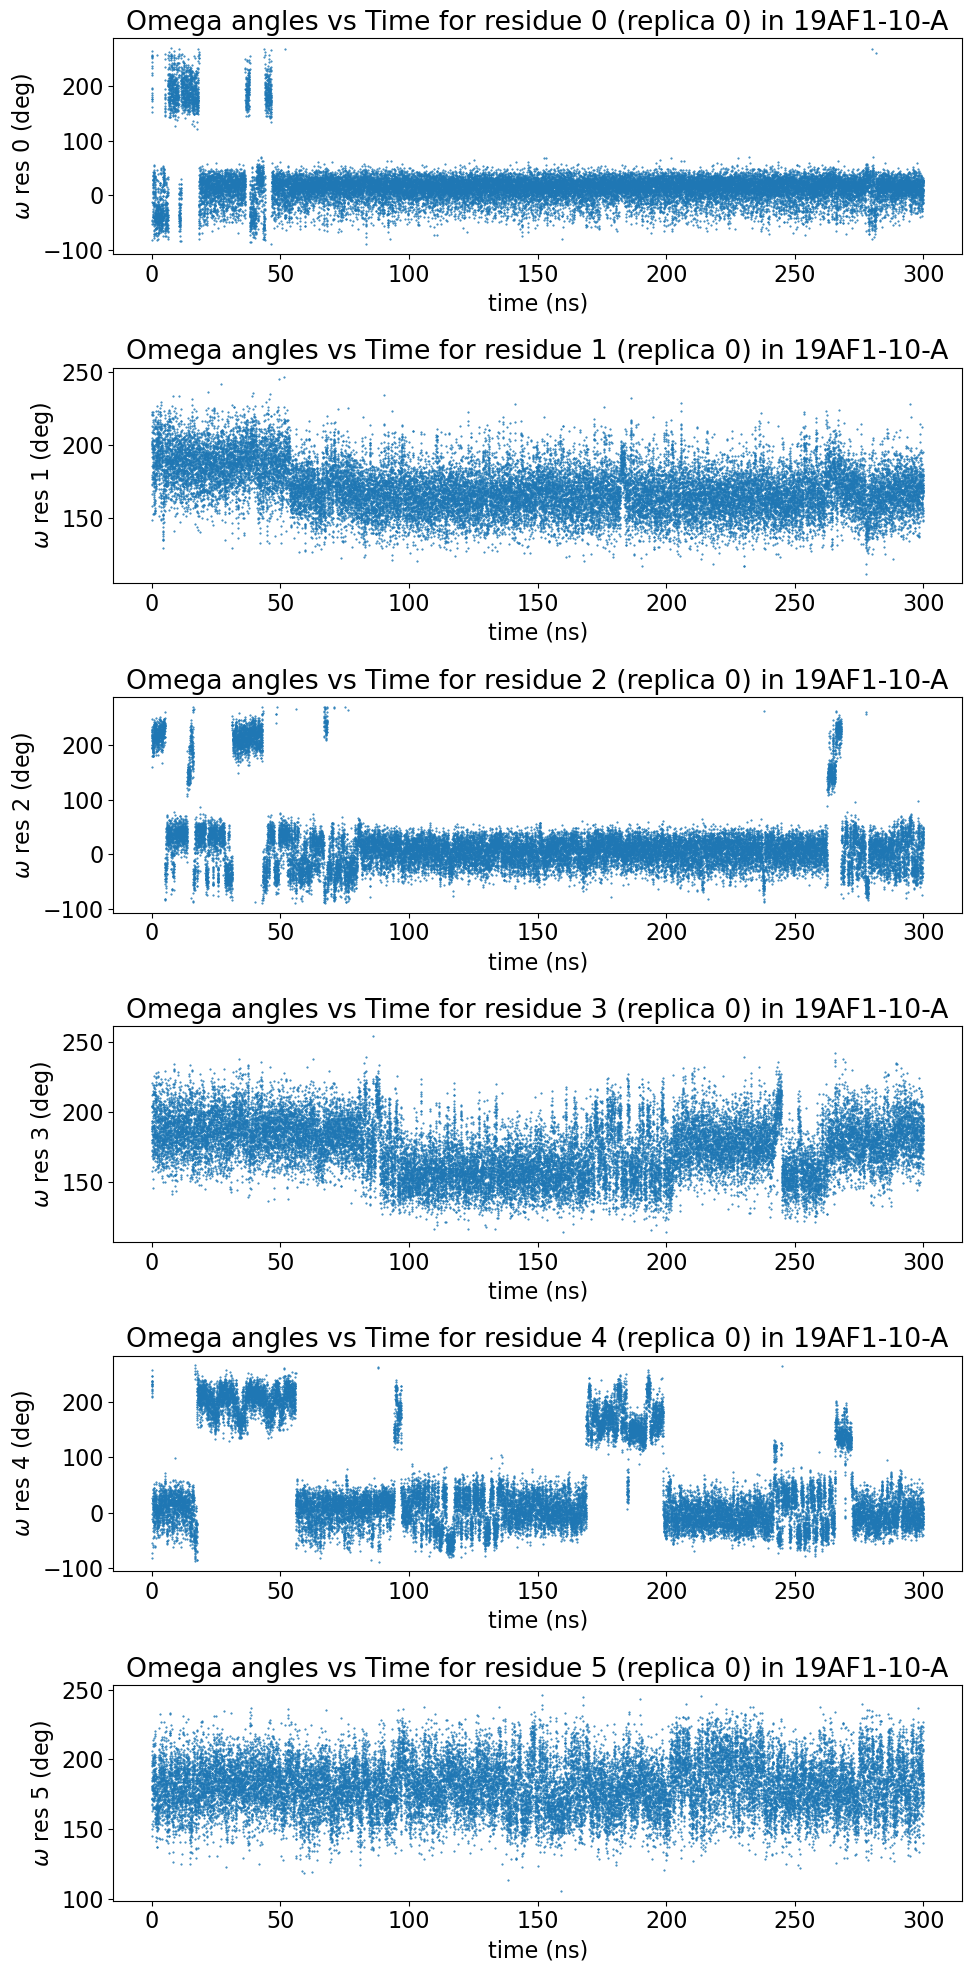

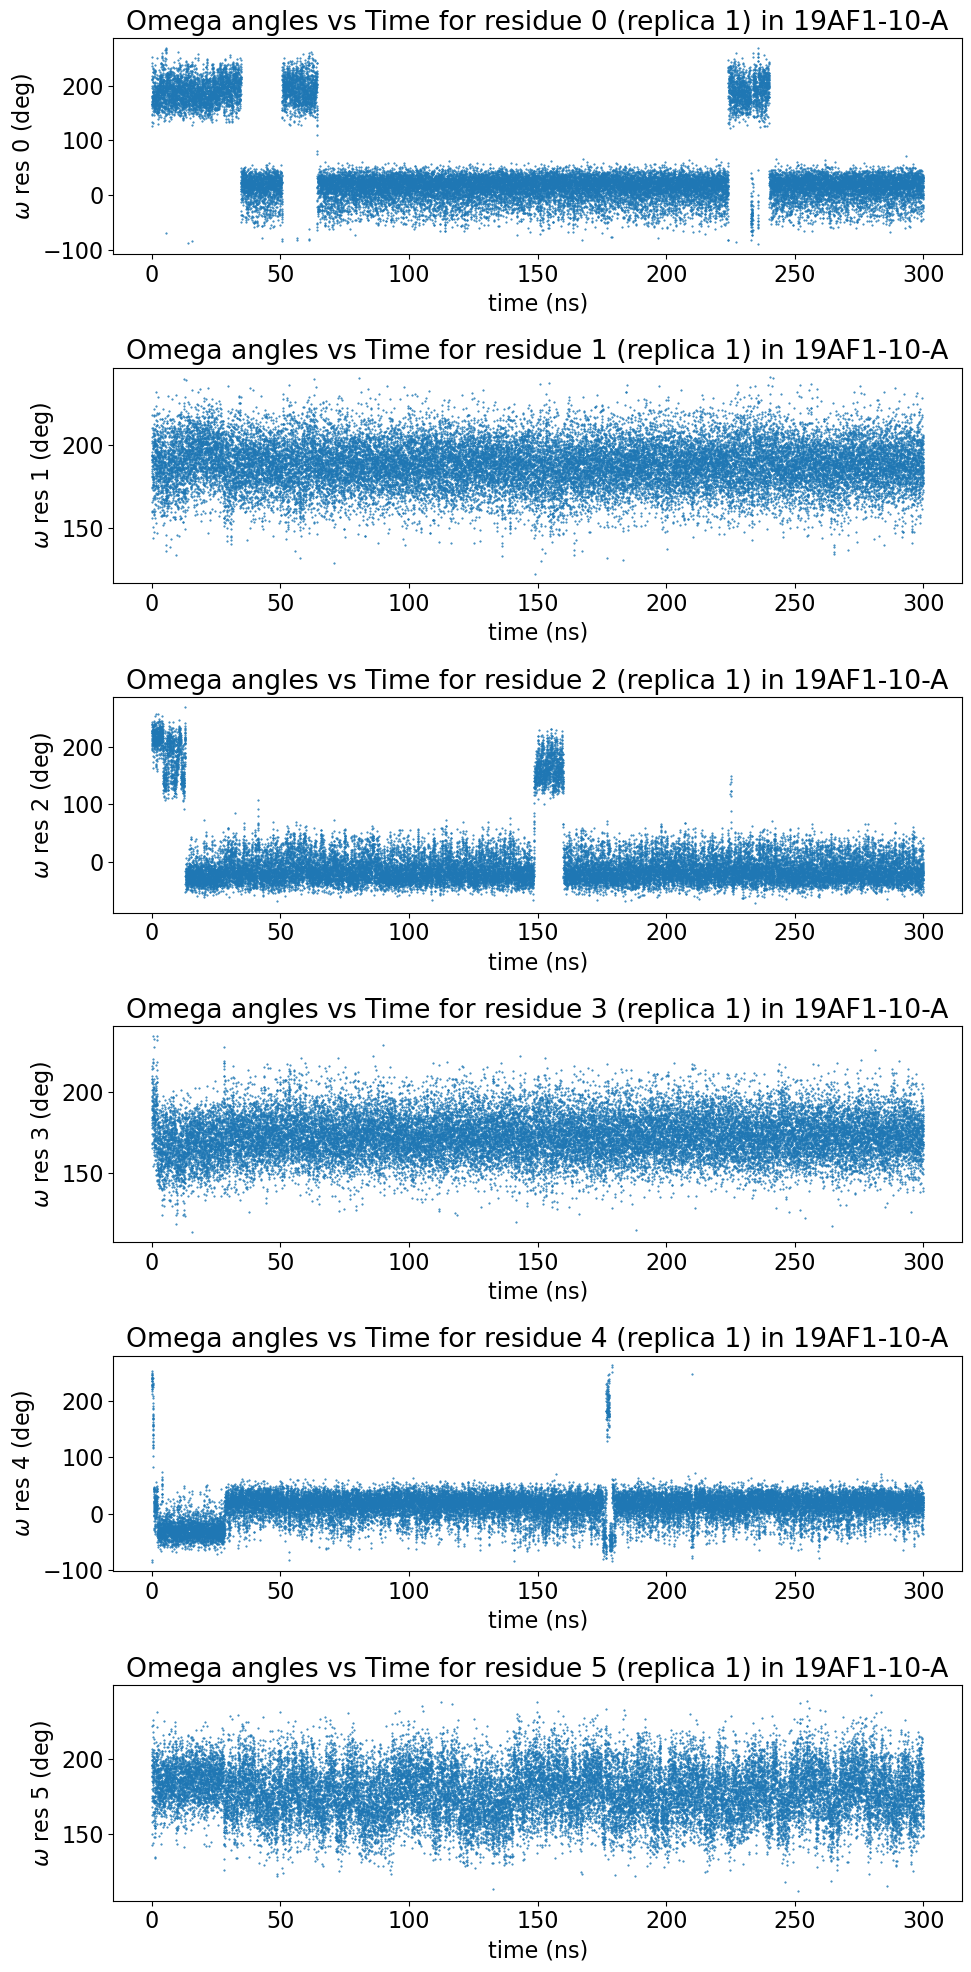

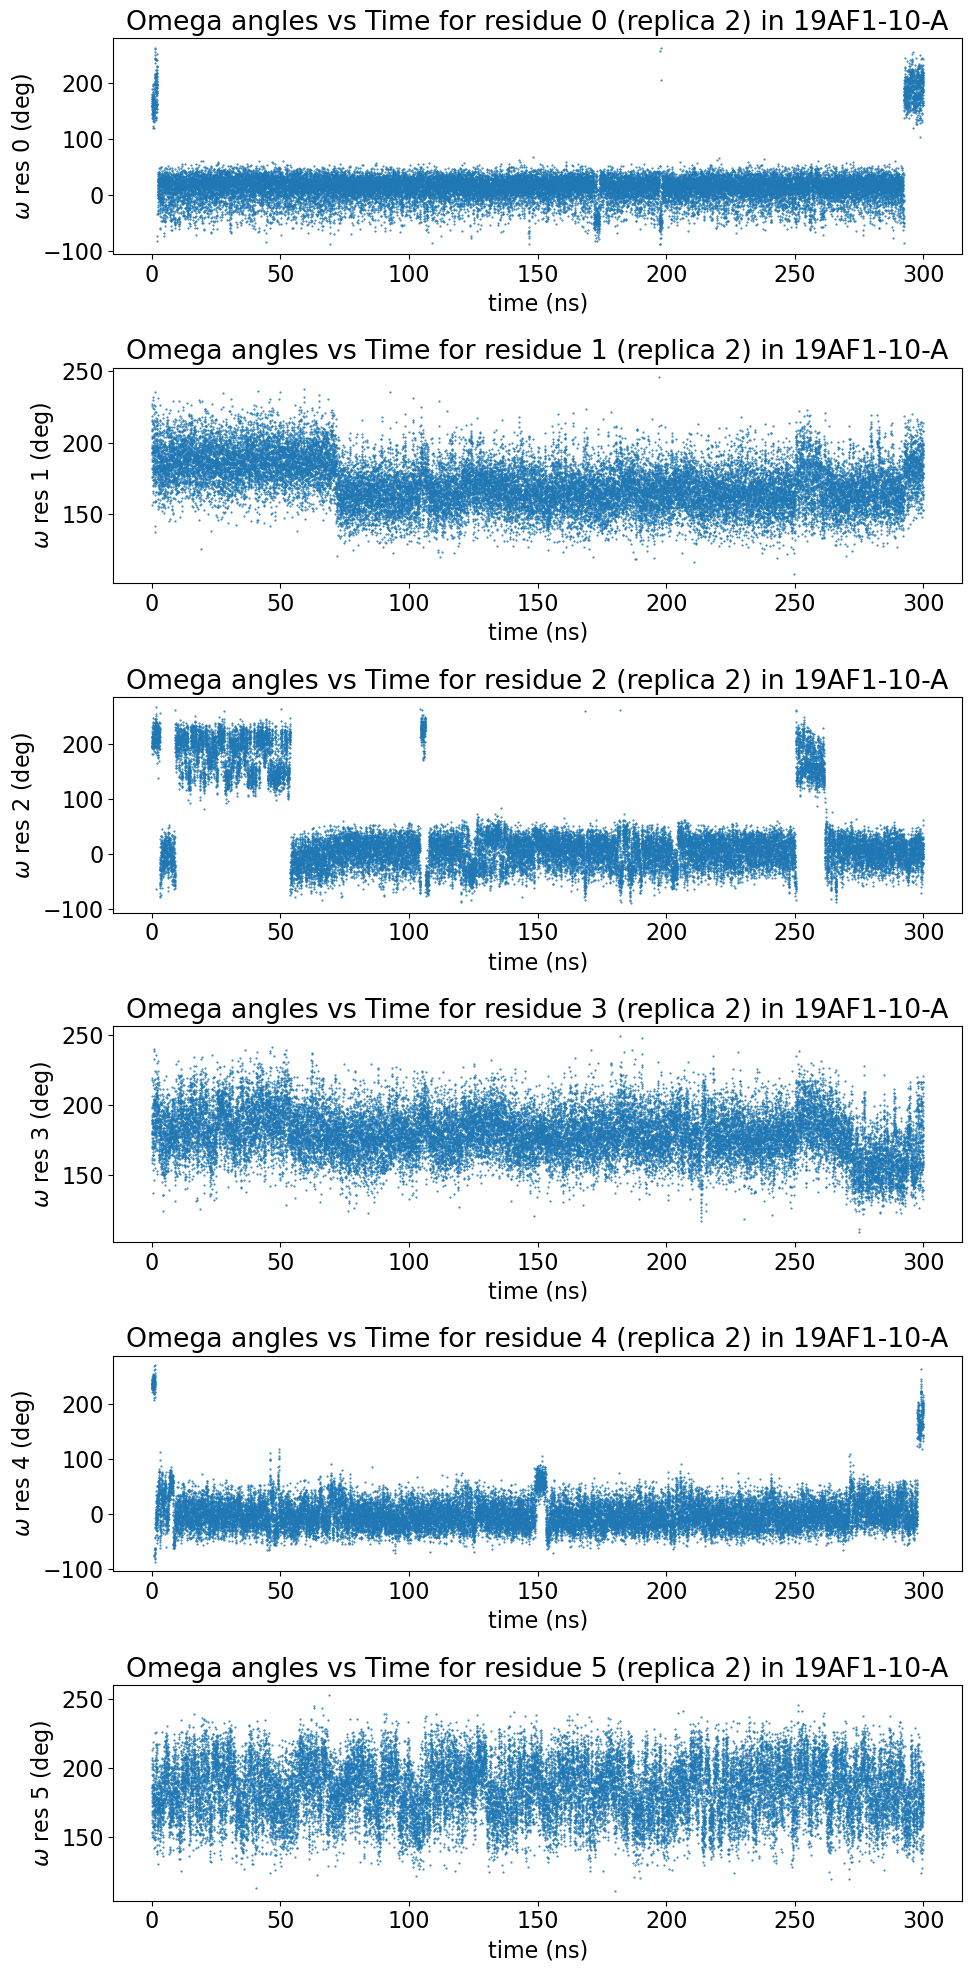

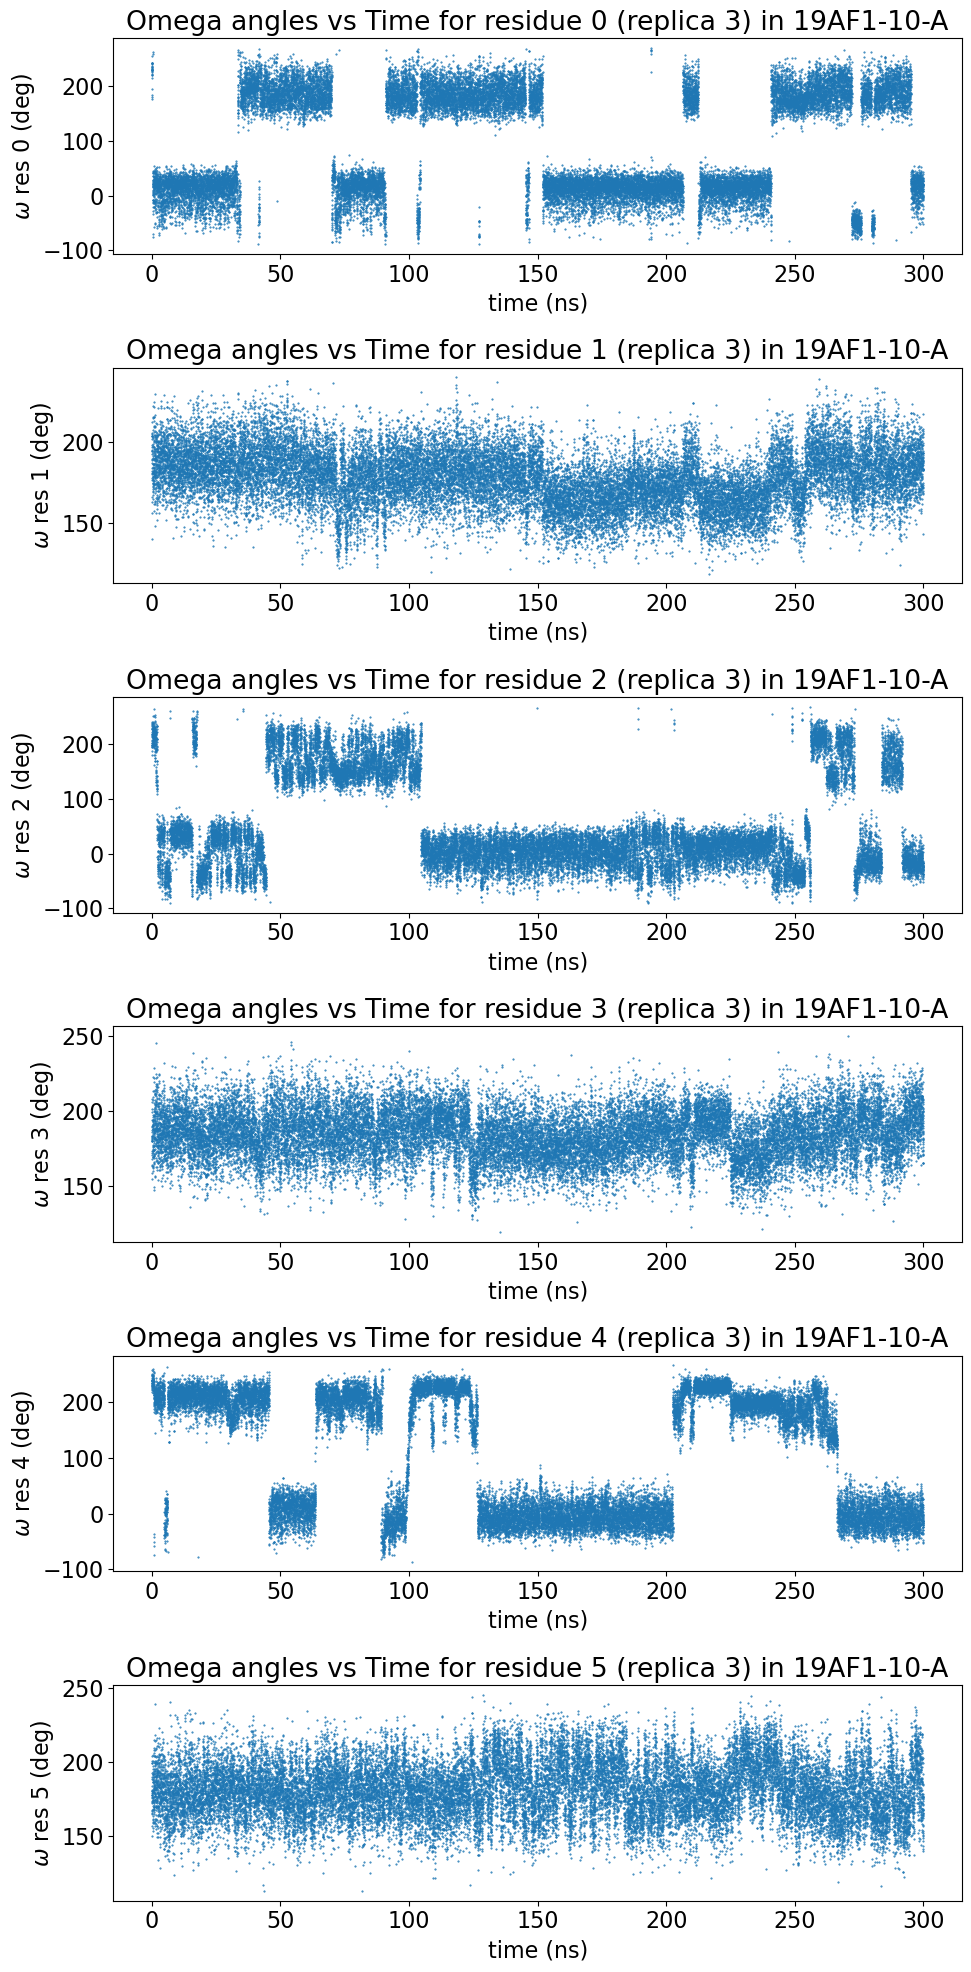

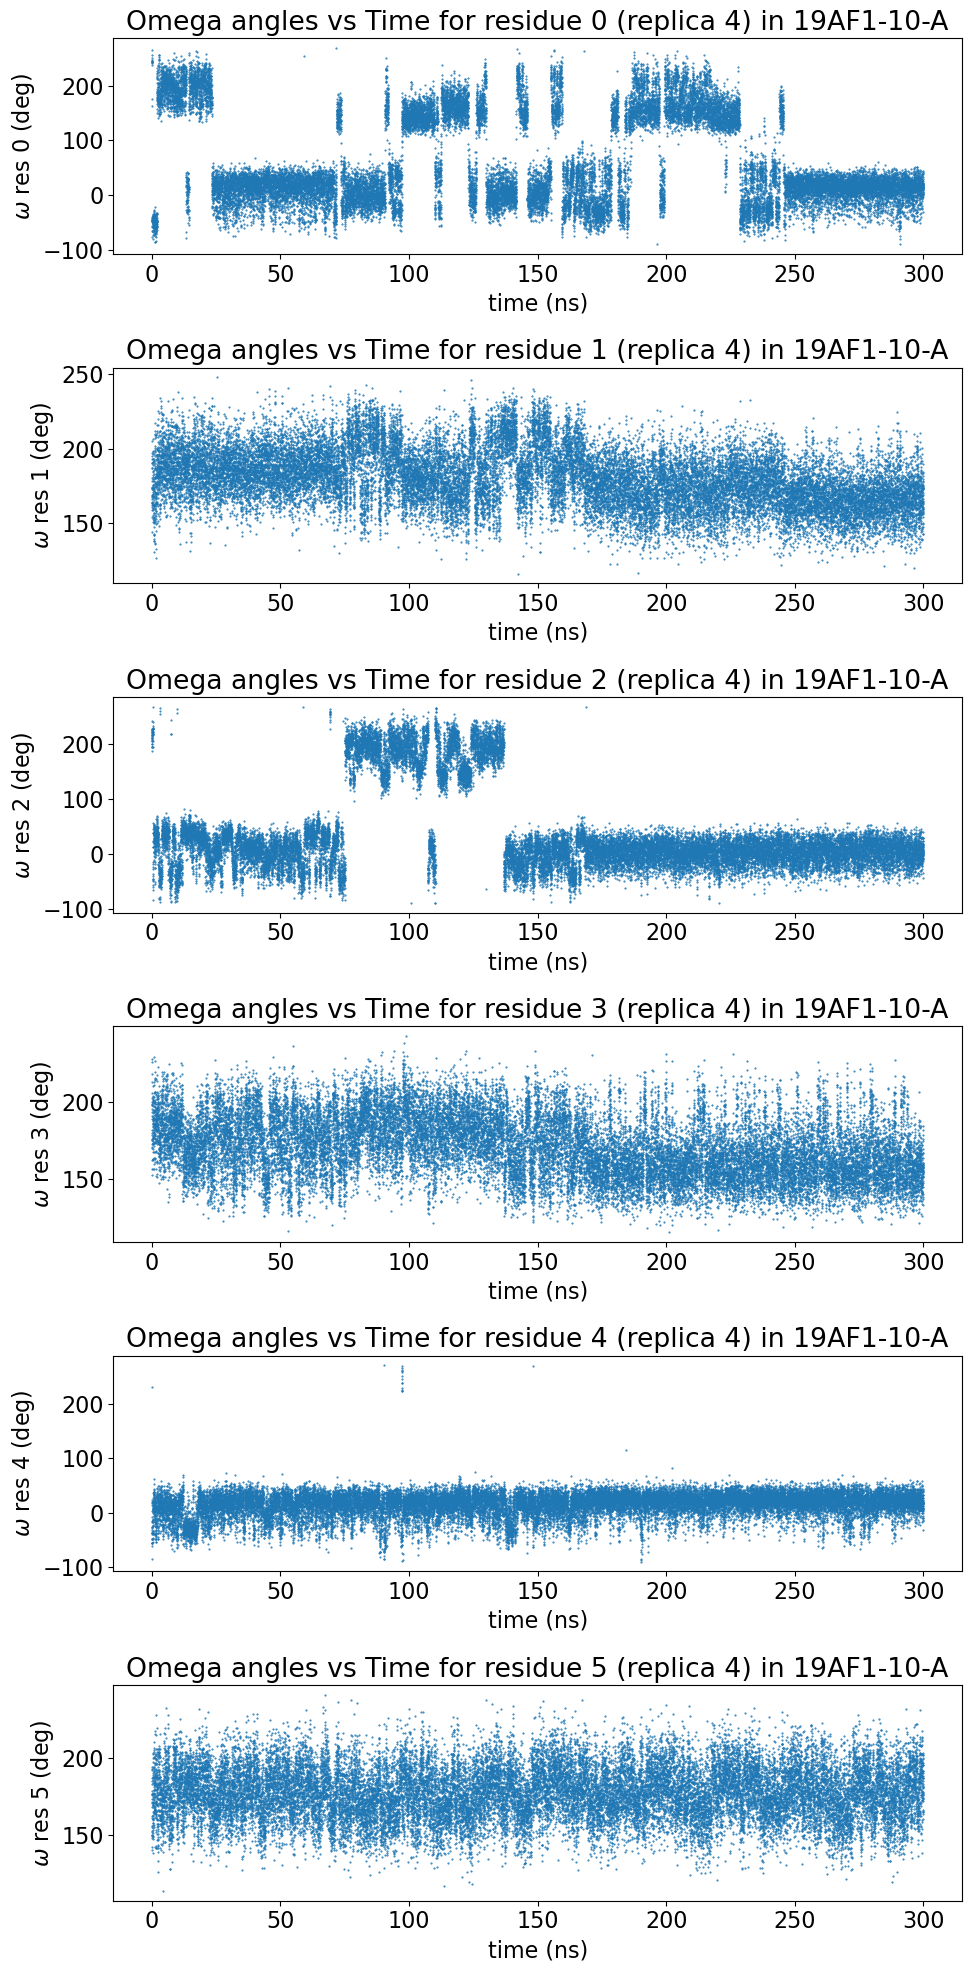

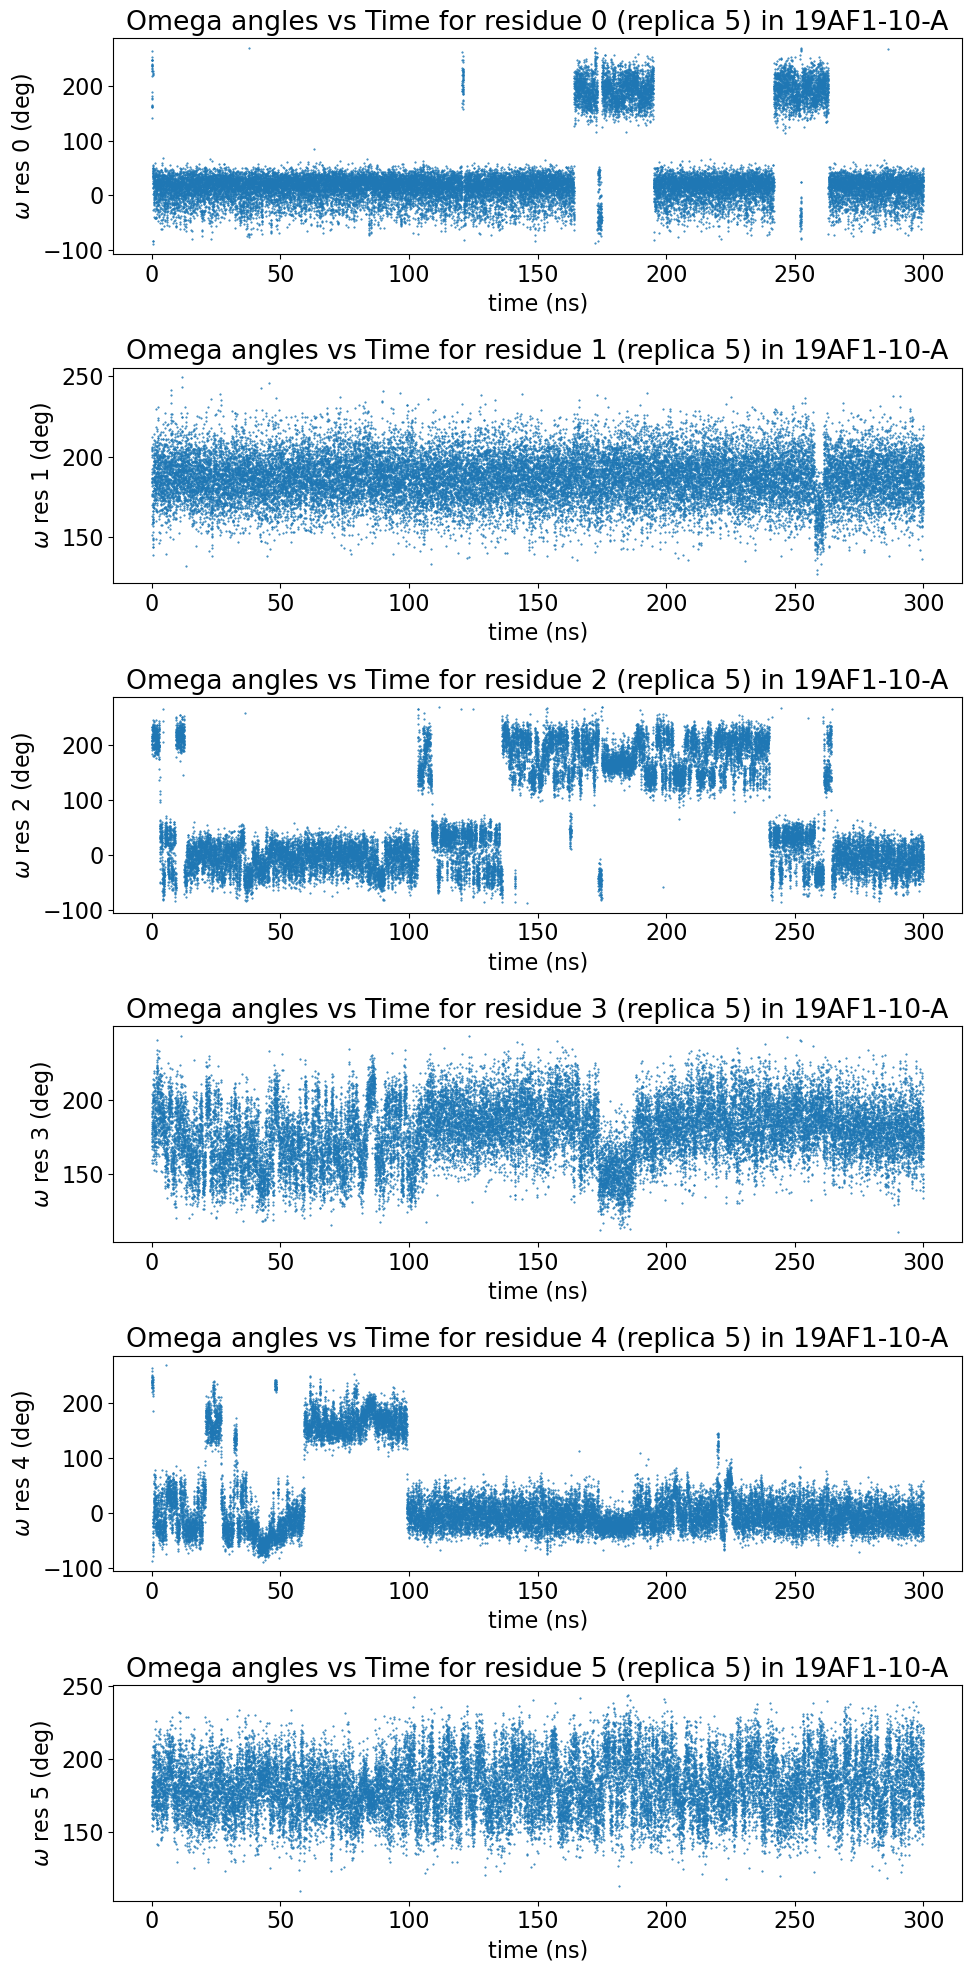

In [22]:
# Adjust omega values into the range (-90, 270)
all_omegas_by_replica = (all_omegas_by_replica + 90.0) % 360.0 - 90.0

start = 0
nsnaps = 30001
nreps = 6
residues_to_plot = [0, 1, 2, 3, 4, 5]
num_residues = len(residues_to_plot)

ShowPlots = True

# Plot omega angles vs time for selected residues for each replica
for i in range(nreps):
    plt.figure(figsize=(10, 20))
    for panel, residue in enumerate(residues_to_plot, 1):
        plt.subplot(num_residues, 1, panel)
        t = np.arange(start, nsnaps) * 0.010  # Time axis in ns
        plt.plot(t, all_omegas_by_replica[i, start:nsnaps, residue], '.', ms=1)
        plt.xlabel('time (ns)')
        plt.ylabel(f'$\\omega$ res {residue} (deg)')
        plt.title(f'Omega angles vs Time for residue {residue} (replica {i}) in 19AF1-10-A')
    plt.tight_layout()
    if ShowPlots:
        plt.show()
    else:
        outfilename = f'omega_data/Omega_angles_vs_Time_residue_{residue}_Replica_{i}_in_19AF1-10-A.png'
        plt.savefig(outfilename)
        print(f"Saved at: {outfilename}")
        plt.clf()  # Clear the figure for the next set of plots